In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI
import time
from google.colab import userdata

# Data Preparation

In [ ]:
# constructing dummy fashion dataset
data = [
    {"name": "Boho Dress", "desc": "Flowy, earthy tones for festival vibes", "vibes": ["boho", "earthy"]},
    {"name": "Denim Jacket", "desc": "Classic blue denim, gives a cool urban look", "vibes": ["urban", "chic"]},
    {"name": "Yoga Pants", "desc": "Comfortable stretch wear for active days", "vibes": ["sporty", "casual"]},
    {"name": "Wool Sweater", "desc": "Soft and warm knit for cozy evenings", "vibes": ["cozy", "minimal"]},
    {"name": "Silk Blouse", "desc": "Elegant and smooth top for evening outings", "vibes": ["elegant", "luxury"]},
    {"name": "Leather Boots", "desc": "Rugged yet fashionable boots for city adventures", "vibes": ["urban", "edgy"]},
    {"name": "Floral Skirt", "desc": "Bright and cheerful skirt for a spring vibe", "vibes": ["boho", "playful"]},
    {"name": "Puffer Jacket", "desc": "Warm puffer with modern streetwear aesthetics", "vibes": ["street", "cozy"]},
]

In [ ]:
df = pd.DataFrame(data)
df.head()

,name,desc,vibes
0,Boho Dress,"Flowy, earthy tones for festival vibes","[boho, earthy]"
1,Denim Jacket,"Classic blue denim, gives a cool urban look","[urban, chic]"
2,Yoga Pants,Comfortable stretch wear for active days,"[sporty, casual]"
3,Wool Sweater,Soft and warm knit for cozy evenings,"[cozy, minimal]"
4,Silk Blouse,Elegant and smooth top for evening outings,"[elegant, luxury]"


# Services for Vibe Matching

## Embedding Generation service

**Utilizing Google's Text Embedding model since OpenAI API key's are paid and there is no free tier available**

In [ ]:
client = OpenAI(api_key = userdata.get("GEMINI_API_KEY"),base_url="https://generativelanguage.googleapis.com/v1beta/openai/")

In [ ]:
def generate_embedding(content, model_name = "gemini-embedding-001"):
  """
  Responsible to generate embedding for any content using OpenAI text embedding model (text-embedding-ada-002)
  """
  try:
    response = client.embeddings.create(input = content, model = model_name)
    return response.data[0].embedding
  except Exception as e:
    print(f"Error generating embedding for content: '{content[:50]}...\n' {e}")
    return None

In [ ]:
# generate and store embeddings for all dummy products
df["embedding"] = df["desc"].apply(lambda x: generate_embedding(x))

# Remove rows where embedding generation failed
df = df.dropna(subset=['embedding']).reset_index(drop=True)

## Vector Search Simulation Service

In [ ]:
def match_vibes(query:str, top_k = 3, threshold = 0.6):
  """
  Return top_k matching items based on cosine similarity.
  """
  if df.empty:
      print("No product data available for matching. Please ensure embeddings were generated successfully.")
      return None

  # computing embedding for given query and perform cosine similarity
  query_embedding = generate_embedding(query)
  if query_embedding is None:
      print("Failed to generate embedding for the query. Cannot perform matching.")
      return None

  df["similarity"] = df["embedding"].apply(lambda x: cosine_similarity([x], [query_embedding])[0][0])

  # getting top k matched products
  top_matches = df.sort_values("similarity", ascending=False).head(top_k)

  # checking for no similarity
  if top_matches.empty or top_matches["similarity"].max() < threshold:
    return None

  return top_matches[["name","desc","similarity"]]

In [ ]:
# testing with sample query
QUERY = "warm"
results = match_vibes(QUERY)

if results is None:
  print("No matched products found")
else:
  for idx, row in results.iterrows():
    print(f"Product: {row['name']}\nDescription: {row['desc']}\n")

Product: Wool Sweater
Description: Soft and warm knit for cozy evenings

Product: Puffer Jacket
Description: Warm puffer with modern streetwear aesthetics

Product: Boho Dress
Description: Flowy, earthy tones for festival vibes



# Evaluation

In [ ]:
queries = [
    "energetic urban chic",
    "cozy fall outfit",
    "luxury elegant evening look",
]

In [ ]:
results = []
for query in queries:
    start_time = time.time()
    matches = match_vibes(query)
    latency = time.time() - start_time

    if matches is not None:
        top_score = matches["similarity"].iloc[0]
        results.append({"query": query, "top_score": top_score, "latency": latency})


In [ ]:
results_df = pd.DataFrame(results)
results_df.head()

,query,top_score,latency
0,energetic urban chic,0.684156,0.295142
1,cozy fall outfit,0.728549,0.295890
2,luxury elegant evening look,0.792106,0.277646


In [ ]:
good_matches = sum(1 for r in results if r["top_score"] >= 0.7)
accuracy = good_matches / len(results)
print(f"Good Match Rate: {accuracy:.2%}")

Good Match Rate: 60.00%


In [ ]:
avg_latency = np.mean([r["latency"] for r in results])
print(f"Average Latency: {avg_latency:.2f} sec")

Average Latency: 0.29 sec


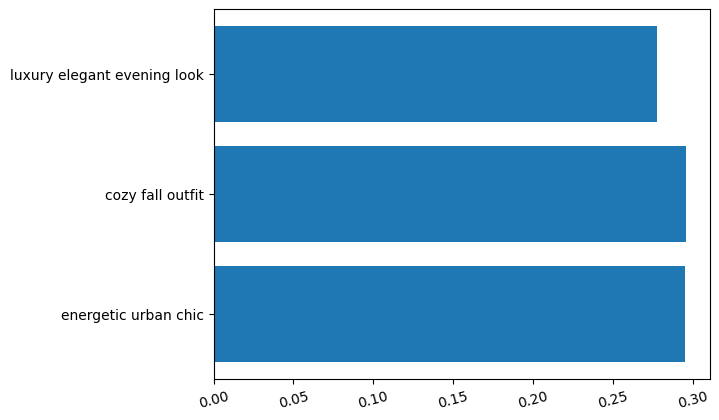

In [ ]:
queries = [r["query"] for r in results]
latencies = [r["latency"] for r in results]
plt.barh(queries, latencies)
plt.title("Latency per Query")
plt.xlabel("Seconds")
plt.ylabel("Query")
plt.xticks(rotation=15)
plt.show()

# Reflections
*   Pinecone or any other vector database can be integrated for scalability and working with large datasets as well making the similarity threshold more dynamic
*   The prototype also manages edge cases like failed product embedding generation, empty dataframes and handling the case where similar products are not found
*   Currently each query's embedding is generated in real time but in production system we can add a batch processing which can reduce the latency and improve the performance of the application.



